(This could be our final notebook for project submission)

In [1]:
import pandas as pd
import os
from config import *
import json
import glob

### Overview of the data (Thomson Reuters News Articles)

This dataset contains articles from 1996 - 2020.
Notebook that generates count is called `generate_all_us_article_count.ipynb`

Output stored at `All_US_Article_Count.csv`

The total number of English articles that talk about the US: 

In [2]:
df = pd.read_csv(os.path.join(TEMP_PATH, 'All_US_Article_Count.csv'), index_col=[0])
df.Count.sum()

19878246

In [3]:
df.date = pd.to_datetime(df.date)
df.set_index('date', inplace=True)

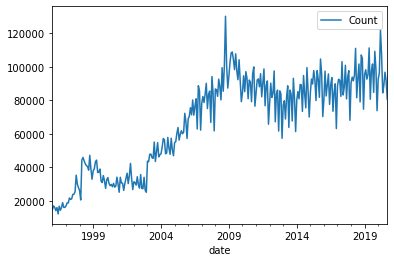

In [4]:
df.plot()

This plot depicts the article count over the years (English, about the US only)

### 1. Filtering the articles based on our themes

We looked into the dataset specifications and identified some tags that were helpful to start our analysis (instead of using a bag of words, word2vec similarity approach, and identifying articles related to "Inflation", "GDP" and "Volatility"

Specifically, Reuters classifies articles based on whether they talk about certain economic indicators. We were able to find exact classifications for Inflation and GDP, but not for Volatility.

#### 1.a. Inflation

We filter the articles each year for the topic 'N2:INFL'. This part of the processing was executed on the grid with the output being a json files for each year that contain the filename and the article ids that talk about inflation.

The processing was undertaken in `Inflation_filter.py`

Command run: `sge_run --grid_submit=batch --grid_mem=25G --grid_SGE_TASK_ID=1-25 ./Inflation_filter.py`


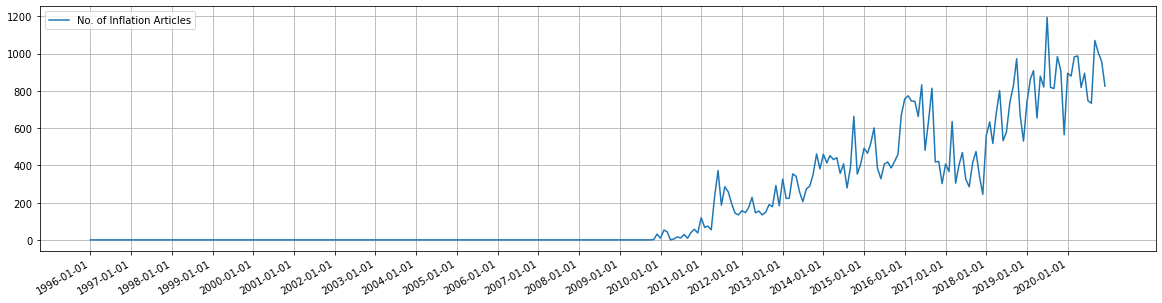

In [25]:
# Looking at the number of articles over the years
infl_files = [TEMP_PATH + '/Inflation/Inflation_Articles_%s.json' % str(year) for year in range(START_YEAR, END_YEAR + 1)]

article_count = dict()
for infl_file in infl_files:
    f = open(infl_file)
    data = json.load(f)
    for key in data:
        yyyymm = key[-15:-9]
        article_count[yyyymm] = len(data[key])
    f.close()

article_count = pd.DataFrame.from_dict(article_count, orient='index')

article_count.index = pd.to_datetime(article_count.index, format='%Y%m')
# article_count.sort_index(inplace=True)
article_count.rename(columns={0: 'No. of Inflation Articles'}, inplace=True)

article_count.plot(grid=True, figsize=(20,5), xticks=[pd.to_datetime(str(y), format='%Y') for y in set(article_count.index.year)])

In [7]:
article_count['No. of Inflation Articles'].sum()

60096

#### 1.b. GDP

We filter the articles each year for the topic 'N2:GDP'. This part of the processing was also executed on the grid as above.

The processing was undertaken in `GDP_filter.py`

Command run: `sge_run --grid_submit=batch --grid_mem=25G --grid_SGE_TASK_ID=1-25 ./GDP_filter.py`

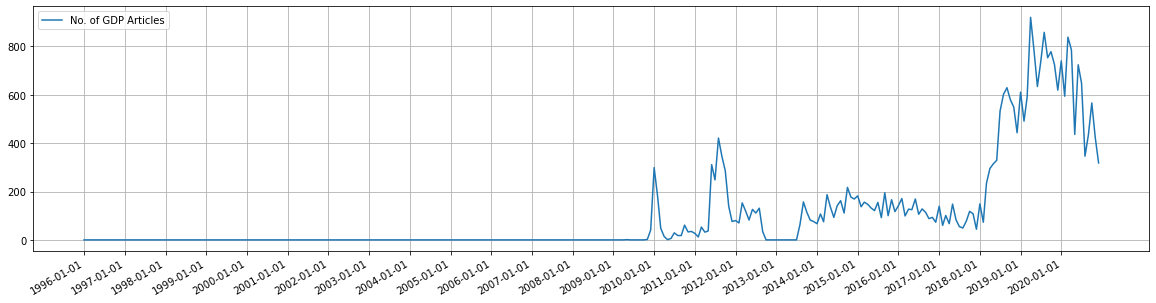

In [24]:
# Looking at the number of articles over the years
gdp_files = [TEMP_PATH + '/GDP/GDP_Articles_%s.json' % str(year) for year in range(START_YEAR, END_YEAR + 1)]

article_count = dict()
for gdp_file in gdp_files:
    f = open(gdp_file)
    data = json.load(f)
    for key in data:
        yyyymm = key[-15:-9]
        article_count[yyyymm] = len(data[key])
    f.close()

article_count = pd.DataFrame.from_dict(article_count, orient='index')

article_count.index = pd.to_datetime(article_count.index, format='%Y%m')
# article_count.sort_index(inplace=True)
article_count.rename(columns={0: 'No. of GDP Articles'}, inplace=True)

article_count.plot(grid=True, figsize=(20,5), xticks=[pd.to_datetime(str(y), format='%Y') for y in set(article_count.index.year)])

In [9]:
article_count['No. of GDP Articles'].sum()

30082

From the graphs above, we see that the Thomson Reuters tags started showing up only around 2009, which means that if we use this approach we would be missing all the articles before this date. For this reason, we decided to try to construct our own filter using word similarity of our themes of interest using Word2Vec. Also, since there was no tag corresponding to volatility we still needed to create a custom filter to be able to extract the articles that mention that theme.

### 2. Word2Vec Similarity Models

Since regimes take some time to shift from one regime to another and our smallest level of analysis is monthly, we thought that using the most similar words within a year would be enough to capture the relevant articles. We decided to construct our word similarity model for each year in our data set (1996-2020), with the output being the 10 most similar words for each of the themes.

The model creation code is at: `similaritymodel.py` - which were able to parallelize for each year.

With the yearly models, the code we used to generate the top similar words for each theme is at `'Create filter words from word2vec models.ipynb'`

#### 2.1 Inflation based on Word2Vec similarity model words filtering

In [10]:
words = pd.read_csv(TEMP_PATH + '/inflation_words.csv', index_col=0)

words.index += 1
words.T

,1,2,3,4,5,6,7,8,9,10
1996,inflationary,cpi,economy,unemployment,gdp,ppi,wages,pressures,wage,economic
1997,inflationary,wage,unemployment,cpi,economy,wages,productivity,joblessness,ppi,pressures
1998,inflationary,unemployment,cpi,wage,productivity,wages,incomes,economy,deflation,gdp
1999,inflationary,cpi,ppi,wage,economy,deflation,deflationary,productivity,gdp,overheating
2000,inflationary,cpi,ppi,wage,productivity,deflation,gdp,economy,pressures,tame
2001,inflationary,cpi,ecb,gdp,deflation,economy,unemployment,rpix,productivity,growth
2002,inflationary,gdp,tame,economy,ecb,rpix,cpi,disinflation,joblessness,deflation
2003,deflation,gdp,disinflation,cpi,policymakers,ecb,economy,inflationary,payrolls,fed
2004,cpi,inflationary,gdp,payrolls,fed,bernanke,benign,greenspan,transitory,deflation
2005,inflationary,cpi,fed,gdp,ppi,payrolls,easing,tame,greenspan,vigilance


The processing was undertaken in `Inflation_filter_v2.py`

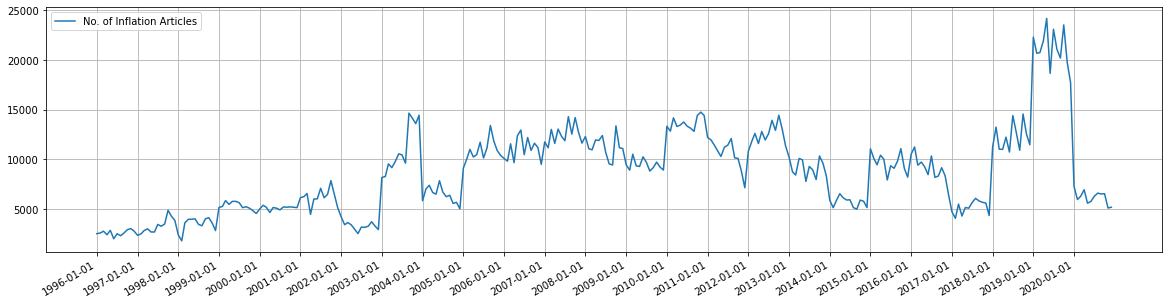

In [23]:
# Looking at the number of articles over the years
infl_files = glob.glob(TEMP_PATH + '/Inflation/Inflation_Articles_v2_*.json')

article_count = dict()
for infl_file in infl_files:
    f = open(infl_file)
    data = json.load(f)
    for key in data:
        yyyymm = key[-15:-9]
        article_count[yyyymm] = len(data[key])
    f.close()

article_count = pd.DataFrame.from_dict(article_count, orient='index')

article_count.index = pd.to_datetime(article_count.index, format='%Y%m')
# article_count.sort_index(inplace=True)
article_count.rename(columns={0: 'No. of Inflation Articles'}, inplace=True)

article_count.plot(grid=True, figsize=(20,5), xticks=[pd.to_datetime(str(y), format='%Y') for y in set(article_count.index.year)])

In [12]:
article_count['No. of Inflation Articles'].sum()

2596767

In [13]:
article_count.to_csv('Summary Stat Tables/Inflation_Article_Count.csv')

#### 2.2 GDP Based

The processing was undertaken in `GDP_filter_v2.py`

In [14]:
words = pd.read_csv(TEMP_PATH + '/gdp_words.csv', index_col=0)

words.index += 1
words.T

,1,2,3,4,5,6,7,8,9,10
1996,cpi,annualised,inflation,economists,ppi,gross,economy,annualized,unemployment,figure
1997,gross,deficit,indx,cpi,drbls,clms,inflation,consumption,unemployment,xhms
1998,cpi,deficit,inflation,economy,employment,eci,consumption,payroll,ppi,unemployment
1999,cpi,ppi,employment,inflation,joblessness,payrolls,unemployment,revision,economy,deficit
2000,cpi,ppi,payrolls,pmi,employment,inflation,economists,unrevised,capex,revised
2001,inflation,cpi,contraction,consumption,payrolls,reading,revised,employment,gross,figure
2002,annualised,inflation,cpi,consumption,payrolls,productivity,economy,gross,employment,reading
2003,inflation,unrevised,economy,fdi,payrolls,oecd,eurozone,insee,contraction,jobless
2004,inflation,payrolls,cpi,durable,ppi,pmi,unrevised,output,jobs,payroll
2005,cpi,ppi,inflation,payrolls,factory,productivity,durable,oecd,jobless,output


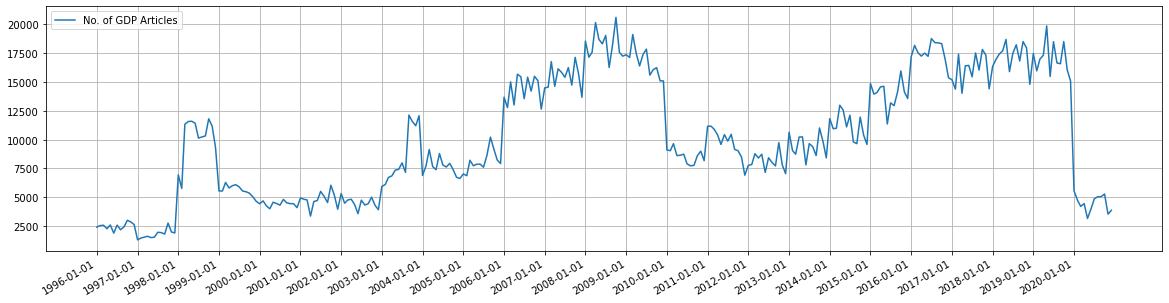

In [22]:
# Looking at the number of articles over the years
infl_files = glob.glob(TEMP_PATH + '/GDP/GDP_Articles_v2_*.json')

article_count = dict()
for infl_file in infl_files:
    f = open(infl_file)
    data = json.load(f)
    for key in data:
        yyyymm = key[-15:-9]
        article_count[yyyymm] = len(data[key])
    f.close()

article_count = pd.DataFrame.from_dict(article_count, orient='index')

article_count.index = pd.to_datetime(article_count.index, format='%Y%m')
# article_count.sort_index(inplace=True)
article_count.rename(columns={0: 'No. of GDP Articles'}, inplace=True)

article_count.plot(grid=True, figsize=(20,5), xticks=[pd.to_datetime(str(y), format='%Y') for y in set(article_count.index.year)])

In [16]:
article_count['No. of GDP Articles'].sum()

3072594

In [17]:
article_count.to_csv('Summary Stat Tables/GDP_Article_Count.csv')

#### 2.3 Volatility Based

The processing was undertaken in `Volatility_filter_v2.py`

In [18]:
words = pd.read_csv(TEMP_PATH + '/volatility_words.csv', index_col=0)

words.index += 1
words.T

,1,2,3,4,5,6,7,8,9,10
1996,volatilities,correction,backwardation,correlation,trend,swings,upside,steepening,downside,fluctuations
1997,volatilities,vols,options,reversal,reversals,nervousness,correction,selloff,curve,inversion
1998,volatilities,vols,options,implied,oex,reversals,anxiety,reversal,activity,nervousness
1999,volatilities,vols,volatilies,implied,options,skew,reversals,flattening,midmarket,weakness
2000,vols,volatilities,gyrations,correction,pullback,swings,inversion,weakness,flattening,bullishness
2001,volatilities,vols,gyrations,underperformance,fluctuations,uncertainty,implied,spike,bullishness,choppier
2002,fluctuations,uncertainty,nervousness,weakness,swings,volatile,fluctuation,movements,strength,bullishness
2003,fluctuations,weakness,volatile,movements,uncertainty,fluctuation,variability,declines,spikes,exposure
2004,movements,fluctuations,fluctuation,adjustment,exposure,bearishness,swings,risk,variability,weakness
2005,fluctuations,sensitivity,exposure,volatile,risk,variability,movements,uncertainty,weakness,bullishness


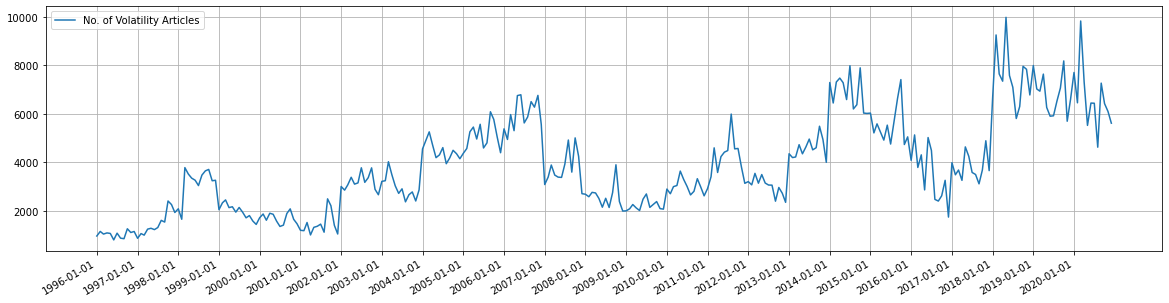

In [26]:
# Looking at the number of articles over the years
infl_files = glob.glob(TEMP_PATH + '/Volatility/Volatility_Articles_v2_*.json')

article_count = dict()
for infl_file in infl_files:
    f = open(infl_file)
    data = json.load(f)
    for key in data:
        yyyymm = key[-15:-9]
        article_count[yyyymm] = len(data[key])
    f.close()

article_count = pd.DataFrame.from_dict(article_count, orient='index')

article_count.index = pd.to_datetime(article_count.index, format='%Y%m')
# article_count.sort_index(inplace=True)
article_count.rename(columns={0: 'No. of Volatility Articles'}, inplace=True)

article_count.plot(grid=True, figsize=(20,5), xticks=[pd.to_datetime(str(y), format='%Y') for y in set(article_count.index.year)])

In [20]:
article_count['No. of Volatility Articles'].sum()

1160075

In [21]:
article_count.to_csv('Summary Stat Tables/Volatility_Article_Count.csv')

Our final article counts for each theme:
- Inflation: ~2.6 Million
- GDP: ~3.1 Million
- Volatility: ~1.2 Million

### 3. Sequential Topic Modeling

To identify regimes within each of our themes, our next task was to use the filtered articles to identify coherent topics that would roughly translate to a "state" of the state variable (theme) - inflation/ GDP/ Volatility.
To do this, we thought it would be best to use a dynamic LDA model, that would optimize the topics to be coherent across the specified time slices.

In our model, this ideally translates to having time slices for each month in our sample (300 months).
The code for these models is at `{THEME}_LDA_monthly.py`.

#### 3.1 Pre-processing the texts

To run a sequential LDA model, we needed a Bag of words representation of each of the articles in our three filtered corpora. The first step was to pre-process the text for each article: tokenize, removing non-alpha characters, stop words, converting to lower case.


Next, we restricted the articles to the effective vocabulary - this is a list of words that exclude the top 50 most frequently occurring words in the sample, and words that appear only once. This step takes time, and was parallelized for each year on the grid. 

Script used: `{THEME}_tokenizing.py`

Command run to parallelize on the grid: `sge_run --grid_submit=batch --grid_mem=25G --grid_SGE_TASK_ID=1-25 {THEME}_filter.py`

After obtaining the tokenized articles within the effective articles, we create Bag of Words. We used `gensim`'s methods to first create a dictionary that contains an integer id for each word in our effective vocabulary.

Then, we create the corpus -- the Bag of Words representation to feed into the LDA model. This is simply a list of list (of tuples): one list for each article in the sample, containing a list of tuples of the form (word id, frequency).

A crucial step here was for us to track the 'time slices', or the number of periods we wanted to study. Since we couldn't maintain the dictionary structure in the corpus, we needed a monthly article count to feed in to the model.

Code:

```
TOKENIZED_ARTICLES_PATH = TEMP_PATH + '/%s/%s_Articles_Tokenized_%s.json'

all_tok_articles = []
for year in years:
    with open(TOKENIZED_ARTICLES_PATH % (THEME, THEME, year)) as f:
        all_tok_articles.extend(json.load(f))
    print(TOKENIZED_ARTICLES_PATH % (THEME, THEME, year), 'done!')

dictionary_all = gensim.corpora.Dictionary(all_tok_articles)
print('Dictionary created!')

# Storing the dictionary
dictionary_all.save(TEMP_PATH + '/%s/%s.dict' % (THEME, THEME))


# Memory friendly corpus creation
class MyCorpus:
    def __iter__(self):
        for doc in all_tok_articles:
            yield dictionary_all.doc2bow(doc)

corpus_memory_friendly = MyCorpus()  # doesn't load the corpus into memory!

# Storing the corpus
gensim.corpora.MmCorpus.serialize(TEMP_PATH + '/%s/%s.mm' % (THEME, THEME), corpus_memory_friendly)

```

Initial model trials were done at `{THEME}_SeqLDA_monthly.py` - monthly time slices, 10 topics, with the dictionary and corpus as created above.

However, we realized that the processing time was way too high, and it was extremely computationally intensive.
The way it works is, after running a regular LDA model, it optimizes across each of the slices. Giving it 300 slices was potentially going to take weeks, so we switched to yearly slices (25 years). (Code: `{THEME}_SeqLDA.py`)

But given the volume, this didn't help much.

#### 3.2 Further restricting the vocabulary

We were hesitant to lose articles at first, so the next step was to cut down on the effective vocabulary. To do this, we used some additional features of gensim's dictionary:
1. Removing extreme words:
We decided to cut it down to words that show up in more than 100k articles, and remove words that show up in more than 80% of the articles.

2. Identifying additional stop words
After our initial runs for the models above, through the logs we were able to track some of the topics and see the words that were being picked up. This helped us identify many additional stop words to remove from the dictionary.

Code for both of these "dictionary filters"

```
# Lists of additional stop words
months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 
          'september', 'october', 'november', 'december', 'jan', 'feb', 'mar', 'apr', 
          'may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'sept', 'daily']
days = ['tuesday', 'day', 'monday', 'thursday', 'wednesday', 'today', 'days', 'friday']
reuters = ['reuterscom', 'reutersnet', 'thomsonreuterscom', 'eikon', 'breakingviews', 'http', 'reuters', 'thomson', 'https', 'www', 'com', 'newsroom']
time = ['gmt', 'years', 'year', 'month', 'months', 'quarter', 'quarters', 'week', 'weekly', 'quarterly', 'monthly', 'yearly']

misc = ['pct', 'would', 'since', 'please', 'per', 'also', 'click', 'first', 'second', 'third', 'fourth', 'inc', 'corp']

def filter_dictionary(theme):
    
    dictionary_all = gensim.corpora.Dictionary.load(TEMP_PATH + '/%s/%s.dict' % (theme, theme))
    print('Length of old dictionary:', len(dictionary_all))
    
    # Filter by thresholds (extreme words)
    MIN_NUMBER_OF_ARTICLES = 100000
    MAX_NUMBER_OF_ARTICLES = 0.8

    dictionary_all.filter_extremes(no_below=MIN_NUMBER_OF_ARTICLES, no_above=MAX_NUMBER_OF_ARTICLES)

    deletable_words = months + days + reuters + time + misc

    # If any of the deletable words remain, store their ids to remove
    del_ids = [k for k,v in dictionary_all.items() if v in deletable_words]

    len(del_ids)

    dictionary_all.filter_tokens(bad_ids=del_ids)

    len(dictionary_all)
    
    dictionary_all.save(TEMP_PATH + '/%s/%s_clean.dict' % (theme, theme))
    print('Clean dictionary saved! New Length: ', len(dictionary_all))

```

With the new dictionaries, we then created newer (and smaller) corpuses for each theme.


Running the models again, we did see that the topics seemed a bit more coherent. We reduced the topics to 5 in the hope that we only retained very important words. However, this still took a long time to process (and is still running at the moment!)

### 3.3 Filtering articles by relevance to theme

Our next approach to get to topics was to cut down on the sample size. To do this in the most meaningful way, we identified the articles in which the theme + similar words appeared above a threshold number of times.

For eg. Only if Inflation and it's "synonyms" appeared over a threshold (10) times in an article for a given year, we included the article in the corpus.

The threshold was determined dynamically, based on the distribution of article-word frequencies for each theme, each year. We set this to be the value of the article at the top 1 percent limit.

First, we started with a less restricted dictionary filter (the same code above but with less restricted filters at the extremes)

    MIN_NUMBER_OF_ARTICLES = 50000
    MAX_NUMBER_OF_ARTICLES = 0.7

Next, we identify the words from our similarity model that still remain in the dictionary:
    
    # Similar words
    words = pd.read_csv(TEMP_PATH + '/%s_words.csv' % THEME.lower(), index_col=0)
    
    year_name_list = dict()
    # words columns are the years
    for col in words.columns:
        reqd_words = list(words[col].values) + [THEME.lower()]   # Also include the theme! 
        reqd_ids = [k for k,v in dictionary_all.items() if v in reqd_words]
        year_name_list[col] = [dictionary_all[i] for i in reqd_ids]

Call these words the 'good words':

    good_words_count_per_year = dict()
    for year in years:
        good_words_count_per_year[year] = []
        with open(TOKENIZED_ARTICLES_PATH % (THEME, THEME, year)) as f:
            a = json.load(f)
            for article in a:
                good_words_count_per_year[year].append(len([word for word in article if word in year_name_list[year]]))
        print(TOKENIZED_ARTICLES_PATH % (THEME, THEME, year), 'done!')

The dictionary contains a yearly list of the total count of the 'good words' in each article. The order is preserved, which is crucial for the filtering.

Next, we iterate through each year, and store just the articles that have good word counts above the threshold. Another very important step here was to store the yearly slices to feed into the seqlda model.

    all_tok_articles = []
    yearly_slices = []
    for year in years:
        # Get the 1% threshold count (the top 1% of most relevant articles)
        x = good_words_count_per_year[year]
        x.sort()
        threshold = x[-int(len(x)*0.01):][0]
        year_article_count = 0
        with open(TOKENIZED_ARTICLES_PATH % (THEME, THEME, year)) as f:
            all_articles = json.load(f)
            article_index = 0
            for articles in all_articles:
                if good_words_count_per_year[year][article_index] >= threshold:
                    all_tok_articles.append(articles)
                    year_article_count += 1    
                article_index += 1
        yearly_slices.append(year_article_count)


Finally, store a new corpus based on this final list of all tokenized articles. 

We tremendously downsized the sample here (to almost 1% !). Total article count for each theme:
- Inflation: 29940
- GDP: 36936
- Volatility: 15234

Running the SeqLDA here with the corresponding yearly slices still takes ages to run. (And they are still running at the moment)

### 4. Regular LDA and taking yearly topic averages

Giving up on the processing time for Sequential LDA, we switched to a regular LDA. We ran a single LDA model for the entire time period, and then using a yearly corpus, identified the top topics for each year by averaging over article probabilities.

The processing is at `Regular LDA - {THEME}.ipynb`

After multiple iterations, we settled for picking 15 topics for each theme.

### 5. Running the Regime switching model with the average topic probabilities

### 6. Next steps, areas of improvement

- Further cleanup some of the words showing up in our topics - For eg "newsxtopnewsaspx", "linkreuterscom"
- Compare the outputs from seqLDA and the regular LDA and see what works better for our use case
- Further calibrate hyperparameters, number of topics for each theme in the regular LDA
- Figure out the best way to maintain a monthly count within the final (much smaller) sample, and use a monthly/ quarterly corpus to look at topic probability drifts over the sample